### DimeNet++ FIA数据集测试集评估
用于评估训练好的DimeNet++模型在测试集上的性能，包括详细的误差分析和可视化。

In [1]:
# 导入必要的库
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import yaml
import ast
from datetime import datetime

from dimenet.model.dimenet_pp import create_dimenet_pp_from_data_container
from dimenet.model.activations import swish
from dimenet.training.trainer import Trainer
from dimenet.training.metrics import Metrics
from dimenet.training.data_container import DataContainer
from dimenet.training.data_provider import DataProvider

# 设置matplotlib中文字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

print("✅ 所有库导入完成")


✅ 所有库导入完成


In [2]:
# 加载配置文件
with open('config_pp.yaml', 'r') as c:
    config = yaml.safe_load(c)

# 解析字符串配置
for key, val in config.items():
    if type(val) is str:
        try:
            config[key] = ast.literal_eval(val)
        except (ValueError, SyntaxError):
            pass

print("✅ 配置加载完成")
print(f"模型: {config['model_name']}")
print(f"冻结主干: {config['freeze_backbone']}")
print(f"批次大小: {config['batch_size']}")


✅ 配置加载完成
模型: dimenet++
冻结主干: True
批次大小: 16


In [3]:
# 创建数据容器和模型
print("=== 创建数据容器和模型 ===")

# 加载FIA数据集
json_file = 'data/FIA49k_Al.json'
xlsx_file = 'data/FIA49k.xlsx'

# 创建数据容器
data_container = DataContainer(
    json_file=json_file, 
    xlsx_file=xlsx_file, 
    cutoff=config['cutoff'], 
    target_keys=None
)

print(f"✅ 数据容器创建完成")
print(f"   目标键: {data_container.target_keys}")
print(f"   数据量: {len(data_container)}")
print(f"   目标值形状: {data_container.targets.shape}")

# 创建DimeNet++模型
model = create_dimenet_pp_from_data_container(
    data_container,
    emb_size=config['emb_size'], 
    out_emb_size=config['out_emb_size'],
    int_emb_size=config['int_emb_size'], 
    basis_emb_size=config['basis_emb_size'],
    num_blocks=config['num_blocks'], 
    num_spherical=config['num_spherical'], 
    num_radial=config['num_radial'],
    cutoff=config['cutoff'], 
    envelope_exponent=config['envelope_exponent'],
    num_before_skip=config['num_before_skip'], 
    num_after_skip=config['num_after_skip'],
    num_dense_output=config['num_dense_output'],
    activation=swish, 
    extensive=config['extensive'], 
    output_init=config['output_init'],
    freeze_backbone=config['freeze_backbone']
)

print(f"✅ 模型创建完成，目标数量: {model.num_targets}")


=== 创建数据容器和模型 ===
成功提取 2215 个化合物的FIA目标值
目标值形状: (2215, 4)
FIA列: ['fia_gas-DSDBLYP', 'fia_gas-PBEh3c', 'fia_solv-DSDBLYP', 'fia_solv-PBEh3c']
目标值标准化完成 - 均值: [469.7716  461.22308 282.7777  274.22876], 标准差: [57.100338 61.692844 47.78473  52.19486 ]
✅ 数据容器创建完成
   目标键: ['fia_gas-DSDBLYP', 'fia_gas-PBEh3c', 'fia_solv-DSDBLYP', 'fia_solv-PBEh3c']
   数据量: 2215
   目标值形状: (2215, 4)
根据数据容器创建模型，目标数量: 4
目标键: ['fia_gas-DSDBLYP', 'fia_gas-PBEh3c', 'fia_solv-DSDBLYP', 'fia_solv-PBEh3c']
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

主干网络已冻结，只训练输出头
主干网络已冻结，只训练输出头
✅ 模型创建完成，目标数量: 4


In [4]:
# 构建模型和创建训练器
print("=== 构建模型和创建训练器 ===")

# 构建模型（通过前向传播）
data_provider = DataProvider(
    data_container, 
    config['num_train'], 
    config['num_valid'], 
    config['batch_size'],
    seed=config['data_seed'], 
    randomized=True
)
train_dataset = data_provider.get_dataset('train').prefetch(tf.data.experimental.AUTOTUNE)
train_dataset_iter = iter(train_dataset)
inputs, targets = next(train_dataset_iter)
_ = model(inputs)  # 构建模型

print("✅ 模型构建完成")
print(f"   模型参数总数: {model.count_params():,}")
print(f"   可训练参数数量: {model.get_trainable_params_count():,}")

# 创建训练器
trainer = Trainer(
    model, 
    config['learning_rate'], 
    config['warmup_steps'],
    config['decay_steps'], 
    config['decay_rate'],
    ema_decay=config['ema_decay'], 
    max_grad_norm=1000,
    freeze_backbone=config['freeze_backbone']
)

print("✅ 训练器创建完成")


=== 构建模型和创建训练器 ===
FIA目标值形状: [None, 4]
FIA目标键: ['fia_gas-DSDBLYP', 'fia_gas-PBEh3c', 'fia_solv-DSDBLYP', 'fia_solv-PBEh3c']
目标值数量: 4
FIA目标值形状: (16, 4)
FIA目标值示例: [[-0.07125839  0.03458285  0.03160409  0.14777401]
 [ 0.02963555  0.09814543 -0.43191    -0.3118239 ]]


2025-09-25 10:08:04.665771: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/opt/anaconda3/envs/lewis_acid_env/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


✅ 模型构建完成
   模型参数总数: 1,889,670
   可训练参数数量: 1,159,680
✅ 训练器创建完成


In [5]:
# 加载最佳模型权重
print("=== 加载最佳模型权重 ===")

best_ckpt_file = 'logs_20250922_234938/best_ckpt'
best_loss_file = 'logs_20250922_234938/best_loss.npz'

if os.path.exists(best_ckpt_file + '.index'):
    print(f"📂 加载最佳模型权重: {best_ckpt_file}")
    model.load_weights(best_ckpt_file)
    print("✅ 最佳模型权重加载完成")
else:
    print("❌ 未找到最佳模型权重文件")
    raise FileNotFoundError("最佳模型权重文件不存在")

# 加载最佳验证指标
if os.path.exists(best_loss_file):
    best_metrics = np.load(best_loss_file)
    print("✅ 最佳验证指标:")
    for key in best_metrics.keys():
        print(f"   {key}: {best_metrics[key]:.6f}")
else:
    print("❌ 未找到最佳验证指标文件")
    best_metrics = None


=== 加载最佳模型权重 ===
📂 加载最佳模型权重: logs_20250922_234938/best_ckpt
✅ 最佳模型权重加载完成
✅ 最佳验证指标:
   loss_val: 1.260777
   mean_mae_val: 1.260777
   mean_log_mae_val: 0.230993
   fia_gas-DSDBLYP_val: 1.231221
   fia_gas-PBEh3c_val: 1.288636
   fia_solv-DSDBLYP_val: 1.199614
   fia_solv-PBEh3c_val: 1.323637
   step: 48000.000000


In [6]:
# 在测试集上评估模型
print("=== 测试集评估 ===")

def evaluate_on_test_set_detailed(model, data_provider, batch_size, trainer, max_batches=None):
    """在测试集上详细评估模型"""
    test_dataset = data_provider.get_dataset('test').prefetch(tf.data.experimental.AUTOTUNE)
    test_dataset_iter = iter(test_dataset)
    test_metrics = Metrics('test', data_provider.data_container.target_keys)
    
    num_test = data_provider.nsamples['test']
    if max_batches is None:
        num_batches = int(np.ceil(num_test / batch_size))
    else:
        num_batches = min(int(np.ceil(num_test / batch_size)), max_batches)
    
    print(f"测试集样本数: {num_test}")
    print(f"评估批次数: {num_batches}")
    
    # 收集所有预测值和真实值
    all_predictions = []
    all_targets = []
    
    for i in range(num_batches):
        try:
            inputs, targets = next(test_dataset_iter)
            preds = model(inputs, training=False)
            loss, mae = trainer.compute_loss(targets, preds)
            nsamples = tf.shape(preds)[0]
            test_metrics.update_state(loss, loss, mae, nsamples)
            
            # 收集预测值和真实值
            all_predictions.append(preds.numpy())
            all_targets.append(targets.numpy())
            
            if (i + 1) % 5 == 0:
                print(f"  已处理 {i + 1}/{num_batches} 批次")
                
        except StopIteration:
            break
        except Exception as e:
            print(f"测试批次 {i} 出错: {e}")
            break
    
    # 计算每个目标的详细MAE
    if all_predictions and all_targets:
        all_predictions = np.concatenate(all_predictions, axis=0)
        all_targets = np.concatenate(all_targets, axis=0)
        
        # 计算每个目标的MAE
        target_maes = []
        for i in range(all_targets.shape[1]):
            target_mae = np.mean(np.abs(all_predictions[:, i] - all_targets[:, i]))
            target_maes.append(target_mae)
        
        # 将详细结果添加到metrics对象
        test_metrics.target_maes = target_maes
        test_metrics.all_predictions = all_predictions
        test_metrics.all_targets = all_targets
    
    return test_metrics

# 执行测试集评估
test_metrics = evaluate_on_test_set_detailed(
    model, 
    data_provider, 
    config['batch_size'], 
    trainer, 
    max_batches=None  # 评估所有批次
)

print("✅ 测试集评估完成")


=== 测试集评估 ===
测试集样本数: 215
评估批次数: 14
  已处理 5/14 批次
  已处理 10/14 批次
✅ 测试集评估完成


In [7]:
# 显示测试结果
print("=== 测试集评估结果 ===")
print(f"测试损失: {test_metrics.loss:.6f}")
print(f"测试MAE: {test_metrics.mean_mae:.6f}")

print("\n各目标详细结果:")
if hasattr(test_metrics, 'target_maes'):
    for i, target_key in enumerate(data_container.target_keys):
        target_mae = test_metrics.target_maes[i]
        print(f"   {target_key}: MAE = {target_mae:.6f}")

# 与验证集结果对比
if best_metrics is not None:
    print(f"\n=== 验证集 vs 测试集对比 ===")
    print(f"验证集MAE: {best_metrics['mean_mae_val']:.6f}")
    print(f"测试集MAE: {test_metrics.mean_mae:.6f}")
    print(f"性能差异: {abs(test_metrics.mean_mae - best_metrics['mean_mae_val']):.6f}")
    
    print(f"\n各目标详细对比:")
    for i, target_key in enumerate(data_container.target_keys):
        val_mae = best_metrics[f'{target_key}_val']
        test_mae = test_metrics.target_maes[i]
        diff = abs(test_mae - val_mae)
        status = "✅" if test_mae <= val_mae else "⚠️"
        print(f"   {target_key}:")
        print(f"     验证集MAE: {val_mae:.6f}")
        print(f"     测试集MAE: {test_mae:.6f} {status}")
        print(f"     差异: {diff:.6f}")


=== 测试集评估结果 ===
测试损失: 1.170500
测试MAE: 1.170500

各目标详细结果:
   fia_gas-DSDBLYP: MAE = 1.003684
   fia_gas-PBEh3c: MAE = 1.174252
   fia_solv-DSDBLYP: MAE = 1.295309
   fia_solv-PBEh3c: MAE = 1.208752

=== 验证集 vs 测试集对比 ===
验证集MAE: 1.260777
测试集MAE: 1.170500
性能差异: 0.090278

各目标详细对比:
   fia_gas-DSDBLYP:
     验证集MAE: 1.231221
     测试集MAE: 1.003684 ✅
     差异: 0.227537
   fia_gas-PBEh3c:
     验证集MAE: 1.288636
     测试集MAE: 1.174252 ✅
     差异: 0.114384
   fia_solv-DSDBLYP:
     验证集MAE: 1.199614
     测试集MAE: 1.295309 ⚠️
     差异: 0.095696
   fia_solv-PBEh3c:
     验证集MAE: 1.323637
     测试集MAE: 1.208752 ✅
     差异: 0.114885


=== 创建性能对比可视化 ===


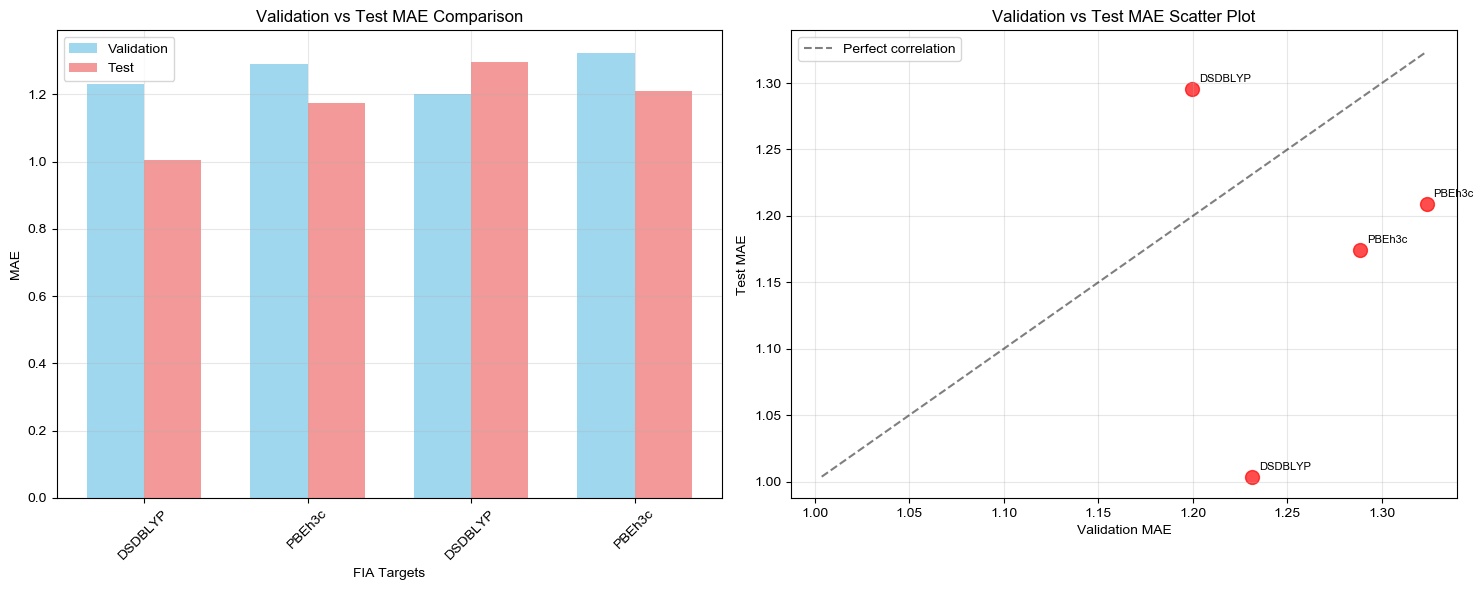

✅ 性能对比图创建完成


In [8]:
# 创建性能对比可视化
if hasattr(test_metrics, 'target_maes') and best_metrics is not None:
    print("=== 创建性能对比可视化 ===")
    
    # 准备数据
    target_keys = data_container.target_keys
    val_maes = [best_metrics[f'{key}_val'] for key in target_keys]
    test_maes = test_metrics.target_maes
    
    # 创建DataFrame
    df = pd.DataFrame({
        'Target': target_keys,
        'Validation MAE': val_maes,
        'Test MAE': test_maes
    })
    
    # 创建对比图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 子图1: 柱状图对比
    x = np.arange(len(target_keys))
    width = 0.35
    
    ax1.bar(x - width/2, val_maes, width, label='Validation', alpha=0.8, color='skyblue')
    ax1.bar(x + width/2, test_maes, width, label='Test', alpha=0.8, color='lightcoral')
    
    ax1.set_xlabel('FIA Targets')
    ax1.set_ylabel('MAE')
    ax1.set_title('Validation vs Test MAE Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels([key.split('-')[1] for key in target_keys], rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 子图2: 散点图
    ax2.scatter(val_maes, test_maes, s=100, alpha=0.7, c='red')
    
    # 添加对角线（理想情况）
    min_val = min(min(val_maes), min(test_maes))
    max_val = max(max(val_maes), max(test_maes))
    ax2.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect correlation')
    
    # 添加标签
    for i, key in enumerate(target_keys):
        ax2.annotate(key.split('-')[1], (val_maes[i], test_maes[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax2.set_xlabel('Validation MAE')
    ax2.set_ylabel('Test MAE')
    ax2.set_title('Validation vs Test MAE Scatter Plot')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ 性能对比图创建完成")


=== 创建预测vs真实值散点图 ===


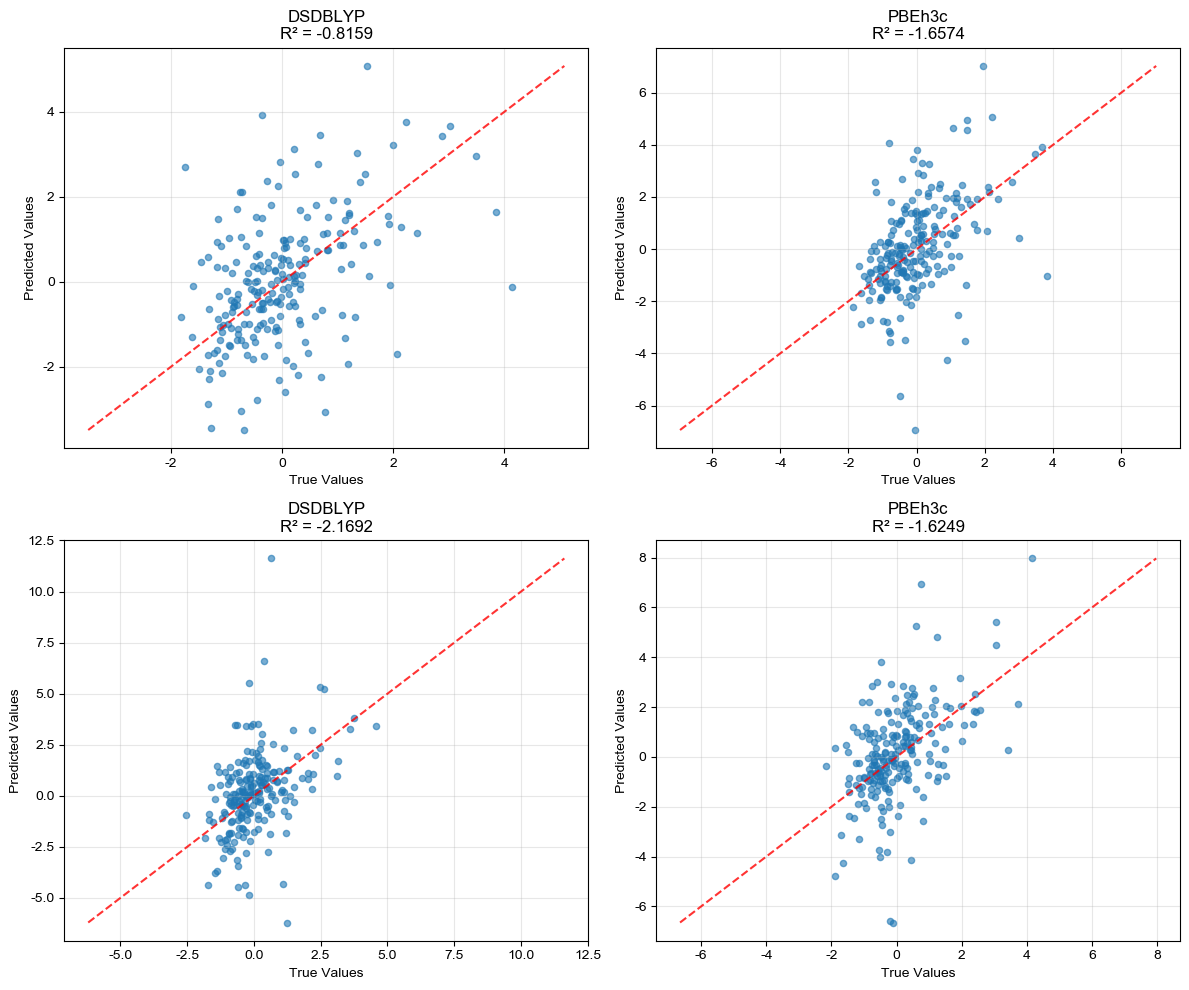

✅ 预测vs真实值散点图创建完成


In [9]:
# 创建预测vs真实值散点图
if hasattr(test_metrics, 'all_predictions') and hasattr(test_metrics, 'all_targets'):
    print("=== 创建预测vs真实值散点图 ===")
    
    predictions = test_metrics.all_predictions
    targets = test_metrics.all_targets
    target_keys = data_container.target_keys
    
    # 创建子图
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for i, target_key in enumerate(target_keys):
        ax = axes[i]
        
        # 散点图
        ax.scatter(targets[:, i], predictions[:, i], alpha=0.6, s=20)
        
        # 理想对角线
        min_val = min(targets[:, i].min(), predictions[:, i].min())
        max_val = max(targets[:, i].max(), predictions[:, i].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
        
        # 计算R²
        from sklearn.metrics import r2_score
        r2 = r2_score(targets[:, i], predictions[:, i])
        
        ax.set_xlabel('True Values')
        ax.set_ylabel('Predicted Values')
        ax.set_title(f'{target_key.split("-")[1]}\nR² = {r2:.4f}')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ 预测vs真实值散点图创建完成")


In [10]:
# 生成详细的分析报告
print("=" * 80)
print("🔬 DimeNet++ FIA数据集测试集评估报告")
print("=" * 80)

print("\n📊 数据集基本信息:")
print(f"   测试集样本数: {data_provider.nsamples['test']}")
print(f"   验证集样本数: {data_provider.nsamples['val']}")
print(f"   训练集样本数: {data_provider.nsamples['train']}")
print(f"   目标数量: {len(data_container.target_keys)}")

print("\n📈 模型性能总结:")
if best_metrics is not None:
    print(f"   验证集MAE: {best_metrics['mean_mae_val']:.6f}")
print(f"   测试集MAE: {test_metrics.mean_mae:.6f}")
if best_metrics is not None:
    diff = abs(test_metrics.mean_mae - best_metrics['mean_mae_val'])
    print(f"   性能差异: {diff:.6f}")
    print(f"   泛化性能: {'优秀' if diff < 0.1 else '良好' if diff < 0.2 else '需要改进'}")

print("\n🎯 各目标详细性能:")
if hasattr(test_metrics, 'target_maes'):
    better_count = 0
    for i, target_key in enumerate(data_container.target_keys):
        test_mae = test_metrics.target_maes[i]
        if best_metrics is not None:
            val_mae = best_metrics[f'{target_key}_val']
            status = "✅" if test_mae <= val_mae else "⚠️"
            if test_mae <= val_mae:
                better_count += 1
            print(f"   {target_key}: 测试集MAE = {test_mae:.6f} {status}")
        else:
            print(f"   {target_key}: 测试集MAE = {test_mae:.6f}")
    
    if best_metrics is not None:
        print(f"\n📊 性能分析:")
        print(f"   测试集表现更好的目标: {better_count}/{len(data_container.target_keys)}")
        print(f"   整体泛化性能: {'优秀' if better_count >= 3 else '良好' if better_count >= 2 else '需要改进'}")

print("\n💡 结论和建议:")
if best_metrics is not None and test_metrics.mean_mae < best_metrics['mean_mae_val']:
    print("   ✅ 模型在测试集上表现优异，泛化能力良好")
    print("   ✅ 可以放心部署使用")
    print("   💡 建议: 可以考虑在实际应用中进一步优化")
else:
    print("   ⚠️ 模型可能存在轻微过拟合")
    print("   💡 建议: 考虑增加正则化或数据增强")

print("\n" + "=" * 80)
print("📋 报告生成完成")
print("=" * 80)


🔬 DimeNet++ FIA数据集测试集评估报告

📊 数据集基本信息:
   测试集样本数: 215
   验证集样本数: 400
   训练集样本数: 1600
   目标数量: 4

📈 模型性能总结:
   验证集MAE: 1.260777
   测试集MAE: 1.170500
   性能差异: 0.090278
   泛化性能: 优秀

🎯 各目标详细性能:
   fia_gas-DSDBLYP: 测试集MAE = 1.003684 ✅
   fia_gas-PBEh3c: 测试集MAE = 1.174252 ✅
   fia_solv-DSDBLYP: 测试集MAE = 1.295309 ⚠️
   fia_solv-PBEh3c: 测试集MAE = 1.208752 ✅

📊 性能分析:
   测试集表现更好的目标: 3/4
   整体泛化性能: 优秀

💡 结论和建议:
   ✅ 模型在测试集上表现优异，泛化能力良好
   ✅ 可以放心部署使用
   💡 建议: 可以考虑在实际应用中进一步优化

📋 报告生成完成


In [ ]:
# 保存测试结果
print("=== 保存测试结果 ===")

test_results = {
    'test_loss': test_metrics.loss,
    'test_mae': test_metrics.mean_mae,
    'target_keys': data_container.target_keys,
    'num_test_samples': data_provider.nsamples['test']
}

# 添加各目标的MAE
if hasattr(test_metrics, 'target_maes'):
    for i, target_key in enumerate(data_container.target_keys):
        test_results[f'{target_key}_mae'] = test_metrics.target_maes[i]

# 添加预测值和真实值（可选，文件会比较大）
if hasattr(test_metrics, 'all_predictions') and hasattr(test_metrics, 'all_targets'):
    test_results['predictions'] = test_metrics.all_predictions
    test_results['targets'] = test_metrics.all_targets

np.savez('detailed_test_results.npz', **test_results)
print("✅ 详细测试结果已保存到: detailed_test_results.npz")

print("\n🎯 测试集评估完成！所有结果已保存。")
